In [1]:
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Toggle Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from skbio.stats.ordination import pcoa
from umap import UMAP
from friendly_guacamole.datasets import (
    Dataset, Metadata, Table, Tables,
    GG97OTUsTree, HMPV13V35,
)
from friendly_guacamole.transforms import (
    UniFrac,
    CLR,
    AsDense,
    RarefactionBIOM,
)
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class PCoA(TransformerMixin):
    def __init__(self, metric='precomputed'):
        self.metric = metric
        self.embedding_ = None

    def fit(self, X, y=None):
        if self.metric == 'precomputed':
            self.ordination_results_ = pcoa(X)
            self.embedding_ = self.ordination_results_.samples
        else:
            raise NotImplemented()
        return self

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.embedding_


class FilterSamples(TransformerMixin):

    def __init__(self, min_count=0):
        self.min_count = min_count

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        Parameters
        ----------
        X : biom.Table

        """
        sample_counts = X.sum(axis='sample')
        insufficient_counts = (sample_counts < self.min_count)
        ids_to_remove = set(X.ids('sample')[insufficient_counts])
        return X.filter(ids_to_remove, invert=True, inplace=False)


In [4]:
class OfficeStudy(Dataset):
    study_id = 10423
    table_artifact_id = 47845

    artifacts = {
        'metadata': Metadata(study_id),
        'table': Table(table_artifact_id),
        'tree': GG97OTUsTree(),
    }

In [5]:
import os
os.listdir('../..')

['friendly-guacamole', 'q2-anomaly-detection', 'scratch', 'umap-benchmarking']

In [6]:
RAREFACTION_DEPTH = 1000
dataset = HMPV13V35('../../friendly-guacamole/hmp')


Files already downloaded and verified


In [7]:
table = dataset['table']
tree = dataset['tree']


In [8]:
preprocessing = Pipeline([
    ('filter_samples', FilterSamples(RAREFACTION_DEPTH))
])

table = preprocessing.fit_transform(table)

In [9]:
table.sum('sample').shape

(8280,)

In [10]:
# import tempfile
# with tempfile.NamedTemporaryFile(mode='w') as f:
#     f.write(tree)
#     f.flush()
#     dm_pipeline = Pipeline([
#         ('subsample', RarefactionBIOM(RAREFACTION_DEPTH)),
#         ('unifrac', UniFrac(f.name)),
#     ])
#     dm = dm_pipeline.fit_transform(table)
dm_pipeline = Pipeline([
    ('subsample', RarefactionBIOM(RAREFACTION_DEPTH)),
    ('unifrac', UniFrac(dataset.apply('tree', 'path'))),
])
dm = dm_pipeline.fit_transform(table)

TypeError: Argument 'tree_filename' has incorrect type (expected str, got _TemporaryFileWrapper)

In [16]:
metadata = dataset['metadata'].set_index('sample_name')
y = metadata.loc[table.ids('sample')]


In [39]:
y.columns

Index(['body_habitat', 'body_product', 'body_site', 'bodysite', 'description',
       'dna_extracted', 'elevation', 'env', 'env_biome', 'env_feature',
       'env_material', 'env_package', 'geo_loc_name', 'host_common_name',
       'host_scientific_name', 'host_subject_id', 'host_taxid', 'latitude',
       'longitude', 'physical_specimen_location',
       'physical_specimen_remaining', 'psn', 'public', 'qiita_study_id',
       'sample_type', 'scientific_name', 'sequencecenter', 'taxon_id', 'title',
       'animations_gradient', 'animations_trajectory'],
      dtype='object')

One component

In [83]:
pcoa_transform = PCoA(metric='precomputed')
X = pcoa_transform.fit_transform(dm)

In [35]:
U1 = UMAP(metric='precomputed', n_components=1).fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


Two component

In [37]:
U2 = UMAP(metric='precomputed', n_components=2, min_dist=0.5).fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


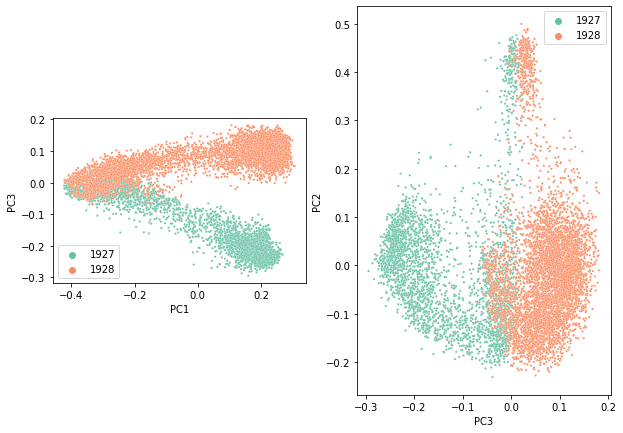

In [80]:
toggle_code()

noise_like = np.random.uniform(size=len(X['PC1']))
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
g0 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC3'],
    # hue=y['period']
    hue=y['qiita_study_id'].tolist(),
    ax=axs[0],
    palette='Set2',
    s=5,
#     legend=False
)
# g0.set_ylabel('PC2')
g0.set_aspect('equal')

g1 = sns.scatterplot(
    x=X['PC3'],
    y=X['PC2'],
    # hue=y['period']
    hue=y['qiita_study_id'].tolist(),
    ax=axs[1],
    palette='Set2',
    s=5,
#     legend=False
)
# g0.set_ylabel('PC2')
g1.set_aspect('equal')

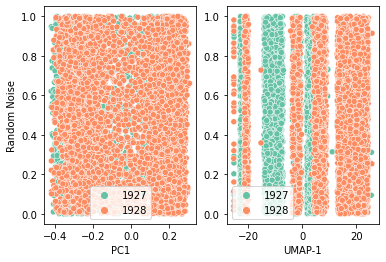

In [84]:
toggle_code()
noise_like = np.random.uniform(size=len(X['PC1']))
fig, axs = plt.subplots(1, 2)
g0 = sns.scatterplot(
    x=X['PC1'],
    y=noise_like,
    # hue=y['period']
    palette='Set2',
    hue=y['qiita_study_id'].tolist(),
    ax=axs[0],
#     legend=False
)
g0.set_ylabel('Random Noise')
# g0.set_aspect('equal')
g1 = sns.scatterplot(
    x=pd.Series(U1[:, 0], name='UMAP-1'),
    y=noise_like,
    palette='Set2',
    hue=y['qiita_study_id'].tolist(),
    ax=axs[1],
#     legend=False,
)
plt.savefig('results/hmp-1d-batch-effect-embeddding.png')
plt.show()

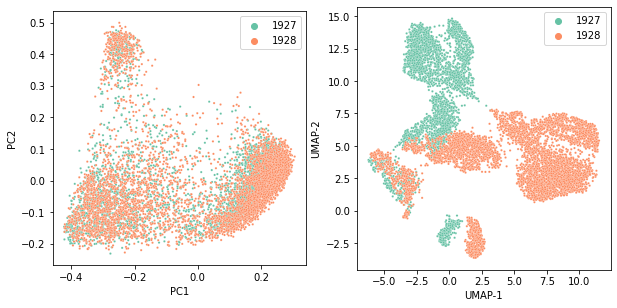

In [72]:
toggle_code()

noise_like = np.random.uniform(size=len(X['PC1']))
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
g0 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC2'],
    # hue=y['period']
    hue=y['qiita_study_id'].tolist(),
    ax=axs[0],
    palette='Set2',
    s=5,
#     legend=False
)
g0.set_ylabel('PC2')
g0.set_aspect('equal')
g1 = sns.scatterplot(
    x=pd.Series(U2[:, 0], name='UMAP-1'),
    y=pd.Series(U2[:, 1], name='UMAP-2'),
    hue=y['qiita_study_id'].tolist(),
    palette='Set2',
    ax=axs[1],
    s=5,
#     legend=False,
)
g1.set_aspect('equal')
plt.savefig('results/hmp-2d-batch-effect-embeddding.png')
plt.show()

In [85]:
y.columns

Index(['body_habitat', 'body_product', 'body_site', 'bodysite', 'description',
       'dna_extracted', 'elevation', 'env', 'env_biome', 'env_feature',
       'env_material', 'env_package', 'geo_loc_name', 'host_common_name',
       'host_scientific_name', 'host_subject_id', 'host_taxid', 'latitude',
       'longitude', 'physical_specimen_location',
       'physical_specimen_remaining', 'psn', 'public', 'qiita_study_id',
       'sample_type', 'scientific_name', 'sequencecenter', 'taxon_id', 'title',
       'animations_gradient', 'animations_trajectory'],
      dtype='object')

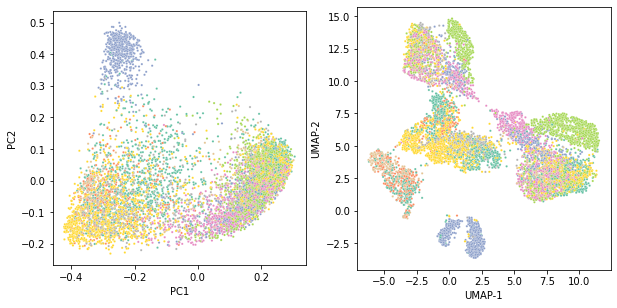

In [89]:
toggle_code()

# hue_var = 'body_habitat'
hue_var = 'body_site'
noise_like = np.random.uniform(size=len(X['PC1']))
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
g0 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC2'],
    # hue=y['period']
    hue=y[hue_var].tolist(),
    ax=axs[0],
    palette='Set2',
    s=5,
    legend=False
)
g0.set_ylabel('PC2')
g0.set_aspect('equal')
g1 = sns.scatterplot(
    x=pd.Series(U2[:, 0], name='UMAP-1'),
    y=pd.Series(U2[:, 1], name='UMAP-2'),
    hue=y[hue_var].tolist(),
    palette='Set2',
    ax=axs[1],
    s=5,
    legend=False,
)
g1.set_aspect('equal')
plt.savefig('results/hmp-body-site-2d-batch-effect-embeddding.png')
plt.show()